In [1]:
import datetime as dt
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
windows = r'C:\Users\Usuario\Downloads\effis_layer\modis.ba.poly.shp'
linux = '~/Descargas/effis_layer/modis.ba.poly.shp'

shp_effis = gpd.read_file(linux)
shp_effis.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,SCLEROPH,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry
0,264477,2000-09-20 00:00:00,2025-03-28 15:01:38.620495,EL,??????,???????? ????????? ?????,981,2.1472392638034616,0,0,5.4192229038849264,73.51738241308041,1.431492842535641,16.46216768915987,1.0224948875254578,0,32.02719647413729,FireSeason,"POLYGON ((24.10056 38.66232, 24.10079 38.65254..."
1,260352,2000-07-31 00:00:00,2000-12-31 12:10:11.414,IT,Crotone,Roccabernarda,56,0,0,0,0,0,58.49056603762549,41.50943396218583,0,0,99.99999999999997,FireSeason,"POLYGON ((16.84555 39.15941, 16.84656 39.15743..."
2,260396,2000-08-25 00:00:00,2000-12-31 12:10:11.414,IT,Crotone,Pallagorio,413,61.36919315401923,0,0,0,0,0,38.63080684595633,0,0,98.7552636258531,FireSeason,"POLYGON ((16.89034 39.33069, 16.89195 39.32436..."
3,260398,2000-07-15 00:00:00,2000-12-31 12:10:11.414,IT,Cosenza,Corigliano-Rossano,88,43.678160919490026,0,0,0,0,0,56.32183908039503,0,0,0,FireSeason,"POLYGON ((16.70885 39.57951, 16.71165 39.57865..."
4,259734,2000-09-02 00:00:00,2000-12-31 12:10:11.414,PT,Beiras e Serra da Estrela,Alvendre,54,0,0,0,0,21.81818181814215,45.45454545446281,32.727272727213226,0,0,0,FireSeason,"POLYGON ((-7.2476 40.59114, -7.24515 40.59178,..."


In [3]:
shp_effis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 92772 entries, 0 to 92771
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          92772 non-null  object  
 1   FIREDATE    92772 non-null  object  
 2   LASTUPDATE  92772 non-null  object  
 3   COUNTRY     92764 non-null  object  
 4   PROVINCE    92772 non-null  object  
 5   COMMUNE     92772 non-null  object  
 6   AREA_HA     92772 non-null  object  
 7   BROADLEA    92121 non-null  object  
 8   CONIFER     92121 non-null  object  
 9   MIXED       92121 non-null  object  
 10  SCLEROPH    92121 non-null  object  
 11  TRANSIT     92121 non-null  object  
 12  OTHERNATLC  92121 non-null  object  
 13  AGRIAREAS   92121 non-null  object  
 14  ARTIFSURF   92121 non-null  object  
 15  OTHERLC     92121 non-null  object  
 16  PERCNA2K    92772 non-null  object  
 17  CLASS       92772 non-null  object  
 18  geometry    92772 non-null  geometry
d

In [4]:
# Comprobamos que el 75% de los 'incendios' presentes en EFFIS tiene una superficie < 120 ha

shp_effis.AREA_HA.astype(int).describe()

count    92772.000000
mean       187.387121
std       1032.621209
min          0.000000
25%         13.000000
50%         40.000000
75%        119.000000
max      96610.000000
Name: AREA_HA, dtype: float64

In [5]:
# Filtramos los grandes incendios forestales, esto es, a partir de 500 ha

shp_effis.AREA_HA = shp_effis.AREA_HA.astype(int)
effis = shp_effis[shp_effis.AREA_HA > 499]

In [6]:
# Pasamos las columnas de inicio de incendio y última actualización a datetime 
effis.FIREDATE = pd.to_datetime(effis.FIREDATE, format='ISO8601')
effis.LASTUPDATE = pd.to_datetime(effis.LASTUPDATE, format='ISO8601')

# Eliminamos los incendios de 2025
effis = effis[effis.FIREDATE.dt.year < 2025]

# Calculamos la duración del incendio
effis['DURATION'] = effis.LASTUPDATE - effis.FIREDATE

/usr/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [7]:
# Calculamos el día juliano pero como si todos los años fueran bisiestos

def dia_juliano_bisiesto(serie):
    dias_meses = [0,31,29,31,30,31,30,31,31,30,31,30]
    lista_dias = []
    for valor in serie:
        dia_juliano = 0
        mes = valor.month
        for index in range(mes):
            dia_juliano += dias_meses[index]
        dia_juliano += valor.day
        lista_dias.append(dia_juliano)
    return lista_dias

effis['DAY_YEAR'] = dia_juliano_bisiesto(effis.FIREDATE)

In [8]:
# Calculamos centroides y extraemos coordenadas
effis['CENTROID'] = effis.geometry.centroid.to_crs('WGS 84')
effis['LAT'], effis['LON'] = effis.CENTROID.y, effis.CENTROID.x

/tmp/ipykernel_19566/2172088228.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  effis['CENTROID'] = effis.geometry.centroid.to_crs('WGS 84')


In [9]:
effis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5996 entries, 0 to 87001
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   id          5996 non-null   object         
 1   FIREDATE    5996 non-null   datetime64[ns] 
 2   LASTUPDATE  5996 non-null   datetime64[ns] 
 3   COUNTRY     5996 non-null   object         
 4   PROVINCE    5996 non-null   object         
 5   COMMUNE     5996 non-null   object         
 6   AREA_HA     5996 non-null   int64          
 7   BROADLEA    5995 non-null   object         
 8   CONIFER     5995 non-null   object         
 9   MIXED       5995 non-null   object         
 10  SCLEROPH    5995 non-null   object         
 11  TRANSIT     5995 non-null   object         
 12  OTHERNATLC  5995 non-null   object         
 13  AGRIAREAS   5995 non-null   object         
 14  ARTIFSURF   5995 non-null   object         
 15  OTHERLC     5995 non-null   object         
 16  PE

In [10]:
effis.LAT.describe()

count    5996.000000
mean       41.316535
std         4.660518
min       -21.134769
25%        37.941639
50%        41.067505
75%        43.141780
max        67.628160
Name: LAT, dtype: float64

In [11]:
effis.loc[effis.LAT < 0, :] # Un incendio en territorio Francés pero fuera de la Europa geográfica, por lo que debemos eliminar este dato

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,...,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry,DURATION,DAY_YEAR,CENTROID,LAT,LON
15006,3415,2011-10-25,2022-01-26 11:57:54.973474,FR,La Réunion,Saint-Leu,2626,93.23653037829219,0,0,...,0,0,0,FireSeason,"POLYGON ((55.40928 -21.16099, 55.40873 -21.161...",3746 days 11:57:54.973474,299,POINT (55.37807 -21.13477),-21.134769,55.37807


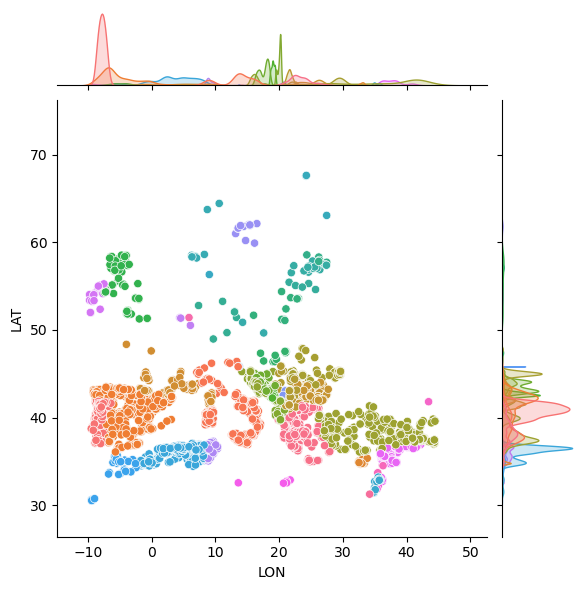

In [12]:
effis = effis.loc[(effis.LAT > 0) & (effis.LON > -10) & (effis.COUNTRY != 'UA'), :] # Eliminamos también islas del Atlántico y Ucrania
sns.jointplot(effis, x='LON', y='LAT', hue = 'COUNTRY', legend=False);

In [13]:
# Cargamos shapefile con datos de todos los países del mundo

df_paises = gpd.read_file('~/Descargas/CNTR_RG_20M_2024_4326.shp')
df_paises.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CNTR_ID    260 non-null    object  
 1   CNTR_NAME  260 non-null    object  
 2   NAME_ENGL  260 non-null    object  
 3   NAME_FREN  241 non-null    object  
 4   ISO3_CODE  260 non-null    object  
 5   SVRG_UN    260 non-null    object  
 6   CAPT       233 non-null    object  
 7   EU_STAT    260 non-null    object  
 8   EFTA_STAT  260 non-null    object  
 9   CC_STAT    260 non-null    object  
 10  NAME_GERM  240 non-null    object  
 11  geometry   260 non-null    geometry
dtypes: geometry(1), object(11)
memory usage: 24.5+ KB


In [25]:
def nombre_pais(country_codes):
    lista_paises = []
    for code in country_codes:
        resultado = df_paises.loc[df_paises.CNTR_ID == code, 'NAME_ENGL']
        pais = resultado.values[0] if len(resultado) > 0 else code
        lista_paises.append(pais)

    return lista_paises

effis['COUNTRY_ID'] = effis.COUNTRY
effis['COUNTRY'] = nombre_pais(effis.COUNTRY)

In [95]:
# Filtramos por los 27 + antigua Yugoslavia

eu_countries = [
    "Germany",
    "Austria",
    "Belgium",
    "Bulgaria",
    "Czechia",
    "Cyprus",
    "Croatia",
    "Denmark",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Estonia",
    "Finland",
    "France",
    "Greece",
    "Hungary",
    "Ireland",
    "Italy",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Malta",
    "Netherlands",
    "Poland",
    "Portugal",
    "Romania",
    "Sweden",
    'North Macedonia', 'Serbia', 'Albania', 'Bosnia and Herzegovina', 'Montenegro', 'KS'
]

effis_eu = effis[effis.COUNTRY.isin(eu_countries)]

In [ ]:
paises = effis_eu.COUNTRY.unique()
effis_eu['Zona'] = effis_eu.loc[]

In [96]:
seleccion = effis_eu.COUNTRY.value_counts()
paises_min = seleccion[seleccion < 100].index

effis_eu.COUNTRY = effis_eu.COUNTRY.replace(paises_min, 'Otros')
effis_eu.COUNTRY.value_counts()

/usr/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


COUNTRY
Portugal                  976
Spain                     690
Italy                     430
Bosnia and Herzegovina    333
Greece                    300
Albania                   213
Romania                   184
Otros                     174
Montenegro                153
North Macedonia           149
Bulgaria                  148
Croatia                   142
France                    128
Name: count, dtype: int64

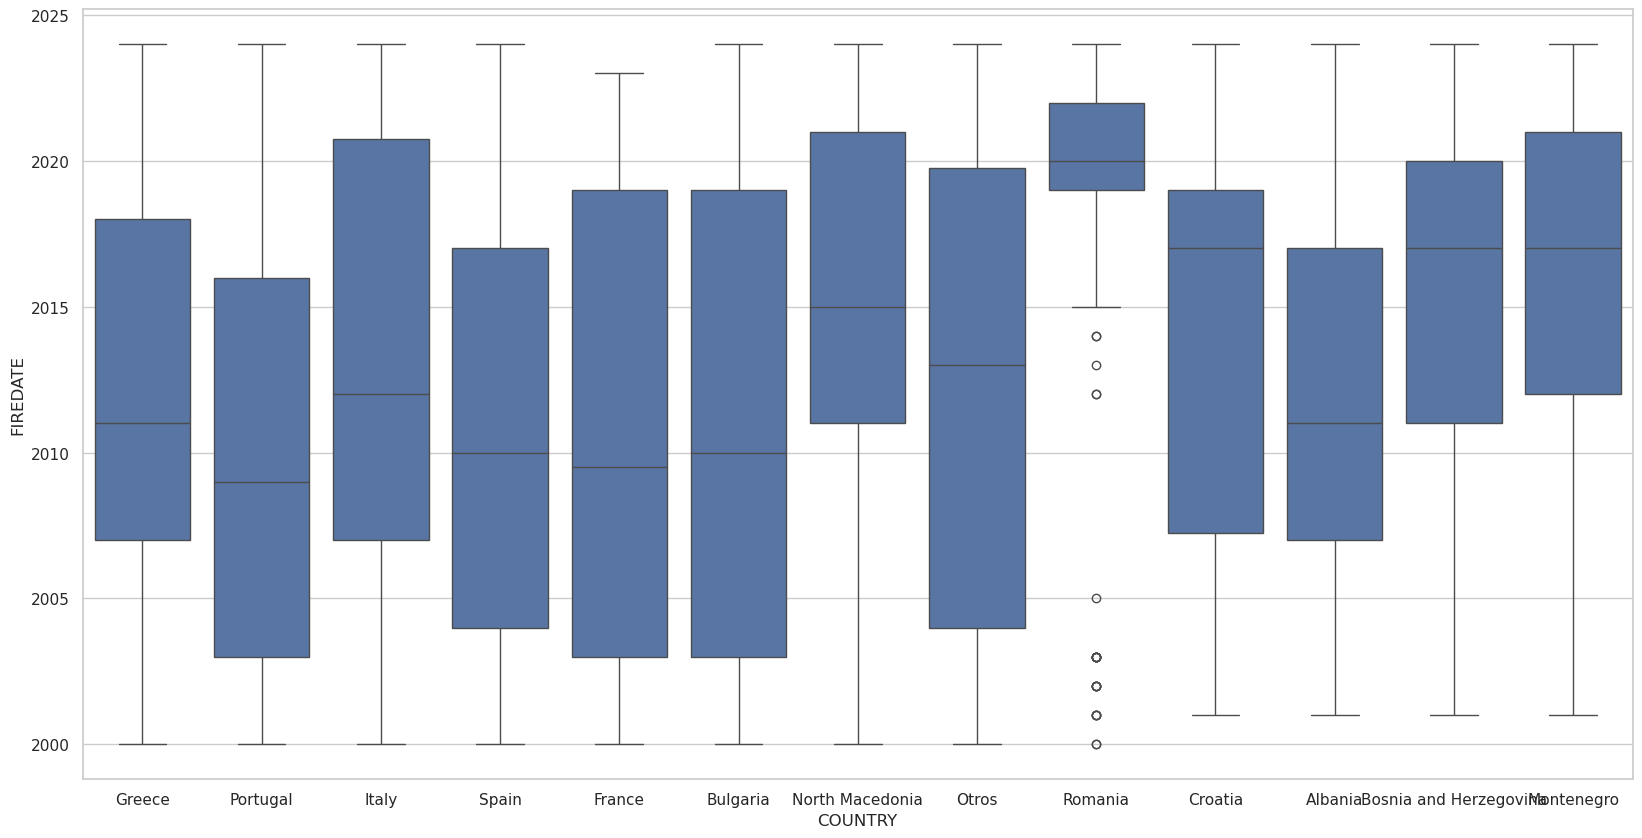

In [101]:
plt.figure(figsize=(20, 10))
sns.boxplot(effis_eu, x='COUNTRY', y=effis_eu.FIREDATE.dt.year);

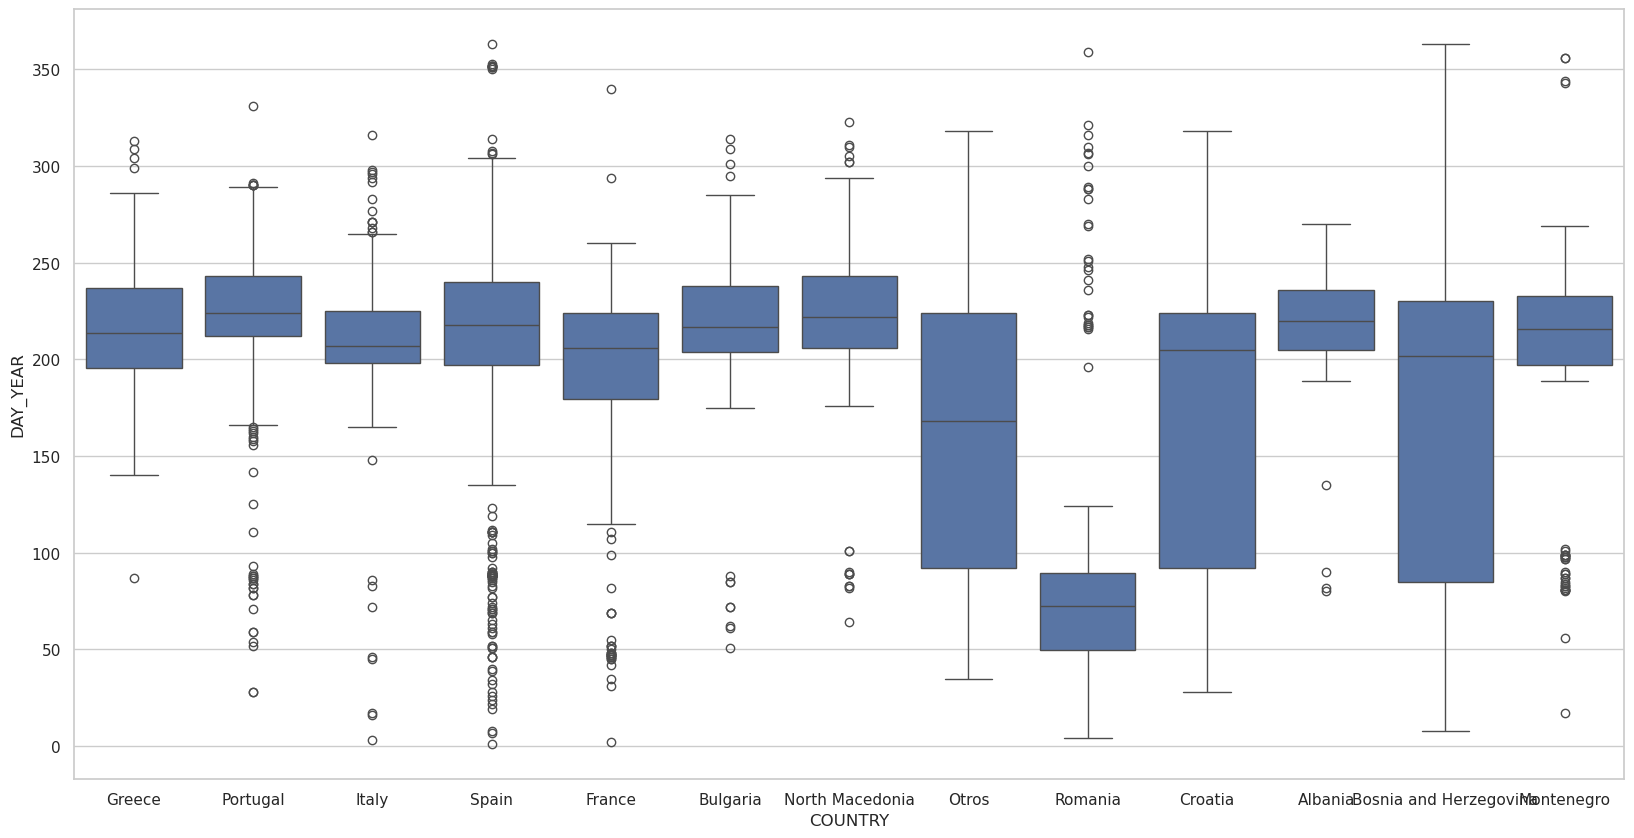

In [97]:
plt.figure(figsize=(20, 10))
sns.boxplot(effis_eu, x='COUNTRY', y='DAY_YEAR');

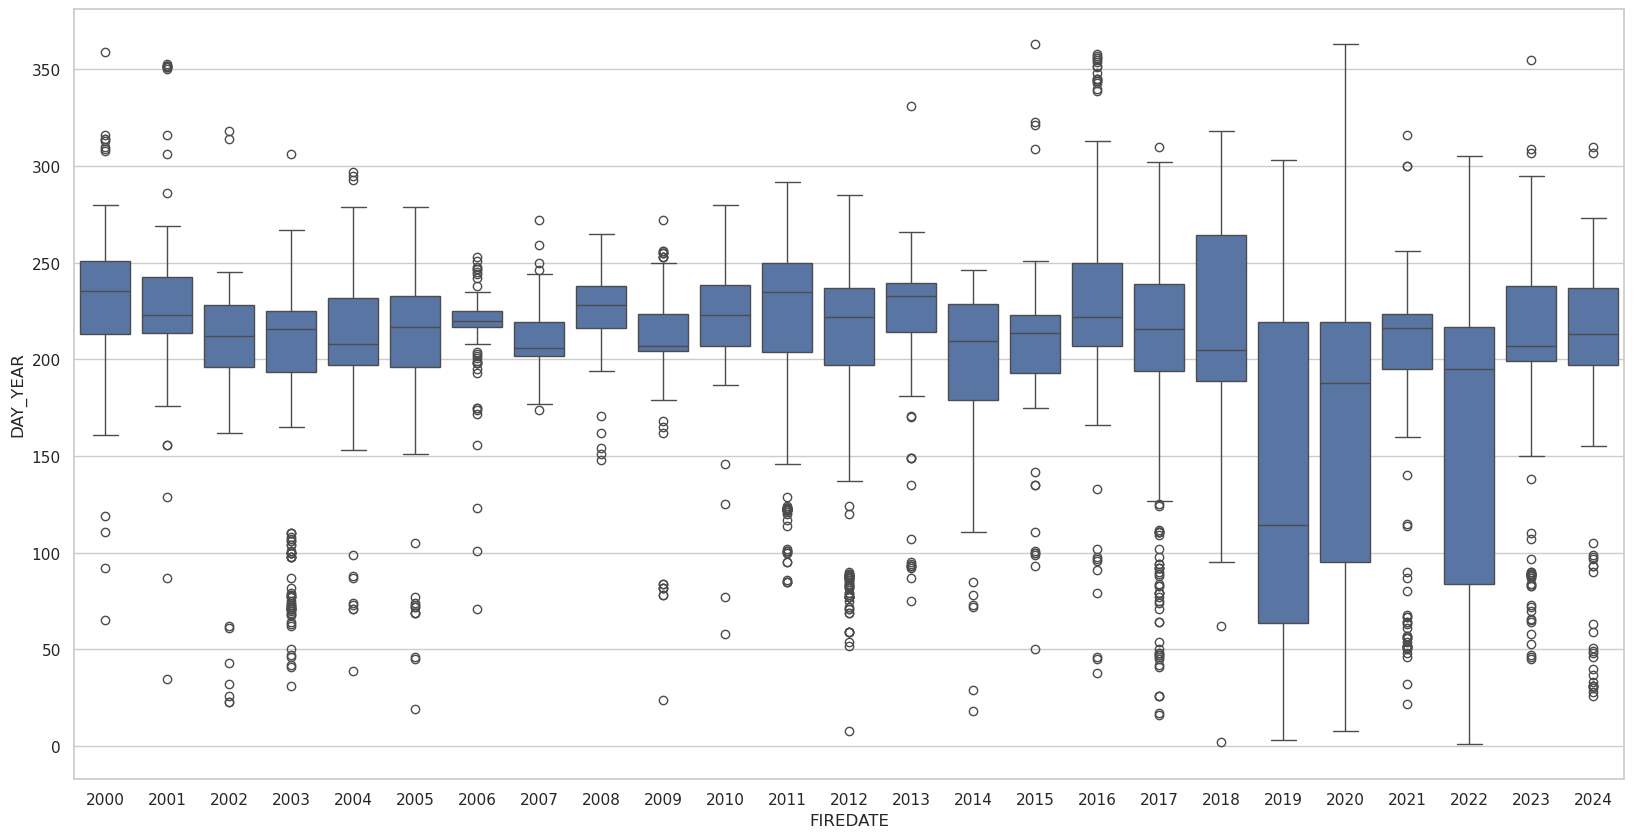

In [89]:
# Distribución de número de grandes incendios por día juliano para cada año

plt.figure(figsize=(20, 10))
sns.boxplot(effis_eu, x=effis.FIREDATE.dt.year, y=effis.DAY_YEAR);

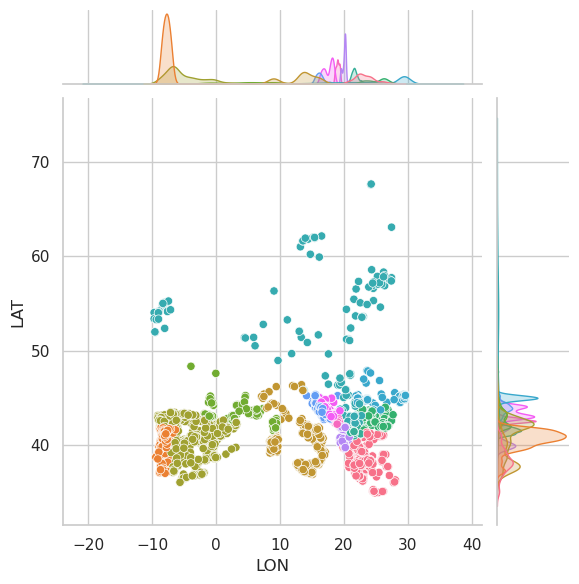

In [99]:
sns.jointplot(effis_eu, x='LON', y='LAT', hue = 'COUNTRY', legend=False);